In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

BERT

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=10
MAX_LEN=512
BATCH_SIZE=5

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EV - Copy1 - Copy7.csv')[['text', 'category ']]
df = df.rename(columns={'text': 'msg', 'category ': 'spam'})
df.head()

,msg,spam
0,what is tesla?,ev
1,tell me about tesla,ev
2,what is ev?,ev
3,tell me about ev,ev
4,what is eletric vehicle?,ev


In [ ]:
category_count = df['spam'].value_counts()

categories = category_count.index

categories

Index(['budget', 'spam', 'common', 'beauty', 'ev', 'ktm'], dtype='object')

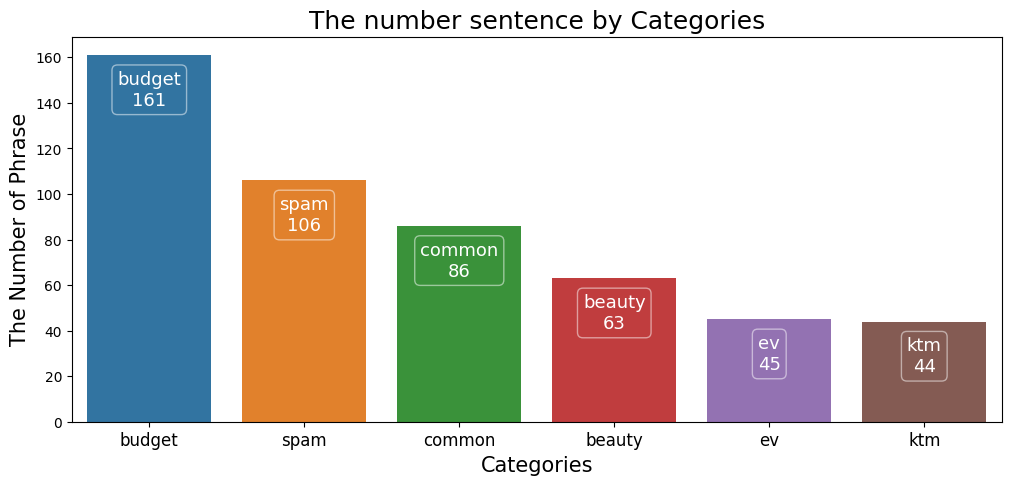

In [ ]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of Phrase', size= 15)

plt.xticks(size = 12)

plt.title("The number sentence by Categories" , size = 18)

plt.show()

In [ ]:
df['spam'].unique()

array(['ev', 'spam', 'beauty', 'ktm', 'budget', 'common'], dtype=object)

In [ ]:
df['encoded_text'] = df['spam'].astype('category').cat.codes

df['encoded_text'].unique()

array([3, 5, 0, 4, 1, 2], dtype=int8)

In [ ]:
data_texts = df['msg'].to_list()

data_labels = df['encoded_text'].to_list()

In [ ]:
class SMSCollectionDataset(Dataset):
    def __init__(self, spam, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.spam = spam
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.msgs)

    def __getitem__(self, i):
        msg = str(self.msgs[i])
        spam = self.spam[i]

        encoding = self.tokenizer.encode_plus(
            msg,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'spam': torch.tensor(spam, dtype=torch.long)
        }


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SMSCollectionDataset(
        spam=df['encoded_text'].to_numpy(),
        msgs=df['msg'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

In [ ]:
df_train, df_test = tts(
    df,
    test_size=0.2,
    random_state=42
)
df_val, df_test = tts(
    df_test,
    test_size=0.5,
    random_state=42
)
df_train.shape, df_test.shape, df_val.shape

((404, 3), (51, 3), (50, 3))

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
d = next(iter(train_data_loader))
d.keys()

dict_keys(['msg', 'input_ids', 'attention_mask', 'spam'])

In [ ]:
d['input_ids'].shape, d['attention_mask'].shape, d['spam'].shape

(torch.Size([5, 512]), torch.Size([5, 512]), torch.Size([5]))

In [ ]:
class SpamClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SpamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SpamClassifier(n_classes=6)
model = model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Training & Evaluation

In [ ]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['spam'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

In [ ]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples
):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['spam'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )


            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_iterator = tqdm(train_data_loader, desc="Training")
    train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        train_iterator,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_iterator = tqdm(val_data_loader, desc="Validation")
    val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        val_iterator,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Your_Directory/best_model7.bin')
        print("Best model saved")
        best_accuracy = val_acc
    print(f"Current best accuracy : {best_accuracy}")


Epoch 1/10
----------


Training: 100%|██████████| 81/81 [00:36<00:00,  2.21it/s]


Train loss 1.6907464427712522 accuracy 0.2995049504950495


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


Validation loss 1.6928322315216064 accuracy 0.28

Best model saved
Current best accuracy : 0.28
Epoch 2/10
----------


Training: 100%|██████████| 81/81 [00:36<00:00,  2.21it/s]


Train loss 1.6576312839249034 accuracy 0.32673267326732675


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Validation loss 1.6231492519378663 accuracy 0.28

Current best accuracy : 0.28
Epoch 3/10
----------


Training: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]


Train loss 1.3302171458432703 accuracy 0.4900990099009901


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Validation loss 0.9788596630096436 accuracy 0.7000000000000001

Best model saved
Current best accuracy : 0.7000000000000001
Epoch 4/10
----------


Training: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]


Train loss 0.7360644278886878 accuracy 0.7920792079207921


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


Validation loss 0.5745357900857926 accuracy 0.88

Best model saved
Current best accuracy : 0.88
Epoch 5/10
----------


Training: 100%|██████████| 81/81 [00:37<00:00,  2.14it/s]


Train loss 0.35648031574156547 accuracy 0.9084158415841584


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


Validation loss 0.42214746251702306 accuracy 0.9

Best model saved
Current best accuracy : 0.9
Epoch 6/10
----------


Training: 100%|██████████| 81/81 [00:38<00:00,  2.12it/s]


Train loss 0.1745565618261879 accuracy 0.9554455445544554


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


Validation loss 0.49612518660724164 accuracy 0.9

Current best accuracy : 0.9
Epoch 7/10
----------


Training: 100%|██████████| 81/81 [00:38<00:00,  2.11it/s]


Train loss 0.0798291465451504 accuracy 0.9826732673267327


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


Validation loss 0.5532230846118182 accuracy 0.9

Current best accuracy : 0.9
Epoch 8/10
----------


Training: 100%|██████████| 81/81 [00:38<00:00,  2.10it/s]


Train loss 0.05449662795635285 accuracy 0.9851485148514851


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Validation loss 0.5696078421548009 accuracy 0.9

Current best accuracy : 0.9
Epoch 9/10
----------


Training: 100%|██████████| 81/81 [00:39<00:00,  2.07it/s]


Train loss 0.035892445858521964 accuracy 0.9925742574257426


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Validation loss 0.5570602184161544 accuracy 0.9

Current best accuracy : 0.9
Epoch 10/10
----------


Training: 100%|██████████| 81/81 [00:39<00:00,  2.07it/s]


Train loss 0.025073477090048937 accuracy 0.995049504950495


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]

Validation loss 0.5570934103336185 accuracy 0.9

Current best accuracy : 0.9


In [ ]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.8823529411764706

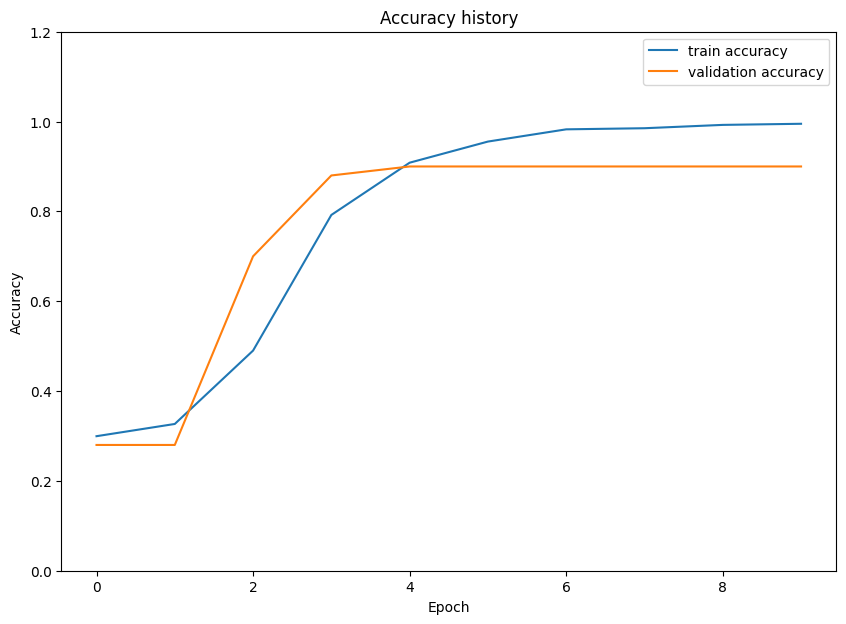

In [ ]:
history['train_acc'] = torch.tensor(history['train_acc'])
history['val_acc'] = torch.tensor(history['val_acc'])
train_acc = history['train_acc']
val_acc = history['val_acc']

plt.figure(figsize=(10, 7))
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Accuracy history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.2])

plt.show()

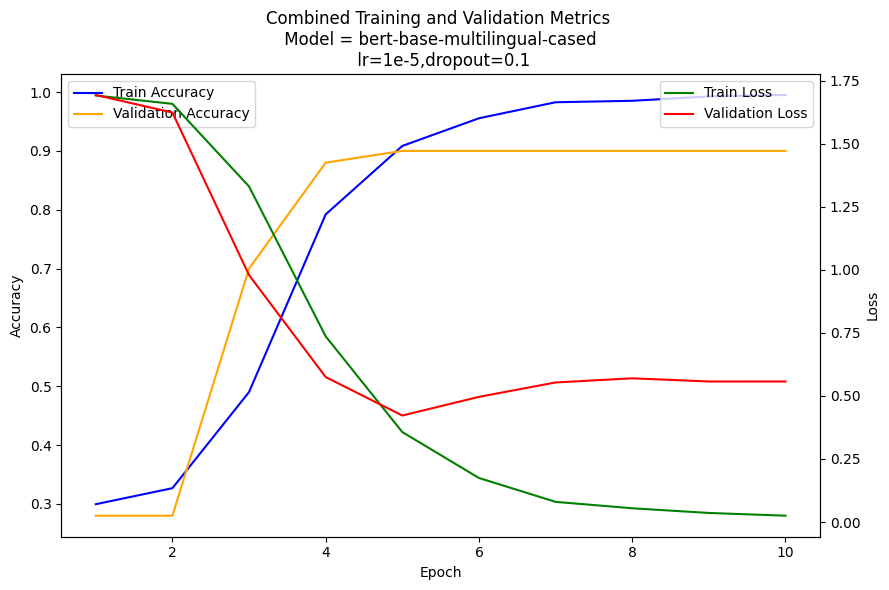

In [ ]:

train_acc = history['train_acc']
val_acc = history['val_acc']
train_loss = history["train_loss"]
val_loss = history["val_loss"]

df = pd.DataFrame({
    'Epoch': range(1, len(train_acc) + 1),
    'Train Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Train Loss': train_loss,
    'Validation Loss': val_loss
})


fig, ax1 = plt.subplots(figsize=(9, 6))

sns.lineplot(x='Epoch', y='Train Accuracy', data=df, ax=ax1, label='Train Accuracy', color='blue')
sns.lineplot(x='Epoch', y='Validation Accuracy', data=df, ax=ax1, label='Validation Accuracy', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='black')


ax2 = ax1.twinx()
sns.lineplot(x='Epoch', y='Train Loss', data=df, ax=ax2, label='Train Loss', color='green')
sns.lineplot(x='Epoch', y='Validation Loss', data=df, ax=ax2, label='Validation Loss', color='red')
ax2.set_ylabel('Loss', color='black')

plt.title('Combined Training and Validation Metrics \n Model = bert-base-multilingual-cased \n lr=1e-5,dropout=0.1')
fig.tight_layout()

save_path = "multi_4.png"
plt.savefig(save_path)
plt.show()


['ev', 'spam', 'beauty', 'ktm', 'budget', 'common']
([3, 5, 0, 4, 1, 2])

In [ ]:
spam_questions = [
    "write me essay about ev",
    "write me essay about budget",
    "write me essay about ktm",
    "write me essay about one-stop beauty centre",
    "hello",
    "good morning",
    "Sing me a song!",
    "bye",
    "where is the charging station",
    "where is the train station",
    "petaling jaya",
    "cheras",
    "I want a hair cut",
    "I want to book for appointment",
    "tell me about budget 2024",
    "what do I get as b40",
    "what is the tax rebate for ev",
    "any benefit for farmer and fintech?",
    "what is the subsidy for petrol",
    "tell me about ev",
]

correct_predictions = 0
total_samples = len(spam_questions)

for text in spam_questions:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    correct_predictions += (predicted_class == 1)

    torch.set_printoptions(precision=5)

    print(f"Question: {text}")
    print("Predicted Class:", predicted_class)
    print()


Question: write me essay about ev
Predicted Class: 5

Question: write me essay about budget
Predicted Class: 5

Question: write me essay about ktm
Predicted Class: 5

Question: write me essay about one-stop beauty centre
Predicted Class: 5

Question: hello
Predicted Class: 2

Question: good morning
Predicted Class: 2

Question: Sing me a song!
Predicted Class: 5

Question: bye
Predicted Class: 2

Question: where is the charging station
Predicted Class: 3

Question: where is the train station
Predicted Class: 4

Question: petaling jaya
Predicted Class: 2

Question: cheras
Predicted Class: 2

Question: I want a hair cut
Predicted Class: 0

Question: I want to book for appointment
Predicted Class: 0

Question: tell me about budget 2024
Predicted Class: 1

Question: what do I get as b40
Predicted Class: 1

Question: what is the tax rebate for ev
Predicted Class: 1

Question: any benefit for farmer and fintech?
Predicted Class: 1

Question: what is the subsidy for petrol
Predicted Class: 1
